In [42]:
%matplotlib inline

import pymysql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from IPython.display import display, HTML

In [13]:
#Create Offense dataframe with only WRs and relevant variables, create redzone dataframe
strSQL = ("Select p.PNAME,o.PLAYER,RA,SRA,RY,TDR,REC,SNP,FP3,FUML,YEAR from offense o INNER JOIN player p on "
          "o.player = p.PLAYER WHERE p.POS1 = "'"RB"'" and o.YEAR = 2015")

df_rbs_2015 = pd.DataFrame(pd.read_sql(strSQL,conn,params=None))

#Use groupby to create a games count, average all fields used for analysis
rb_games = df_rbs_2015.groupby(['PNAME'])['RA'].count()
rbs = df_rbs_2015.groupby(['PNAME']).agg(np.mean)
rbs['games'] = rb_games

The use of data in sports has grown exponentially over the past few years; many professional teams now use data analytics in their game preparation. In this post I will combine the two by using sports data and machine learning. I will demonstrate a simple method, K-means clustering, that groups similar obeservations together using NFL data on running backs.

**Data**

The data for this analysis is from Armchair Analysis (http://www.armchairanalysis.com/). The dataset provides a level of granularity I have yet to see from the major sites like ESPN, NFL.com, and pro-football-reference. The data is broken out into several tables (players, play-by-play, offense, etc.), which can be loaded into a database or consumed separately as csv files. I loaded the data into a google sql database and used python to query the database. For this example, I used the 'offense' table, which contains offensive player statistics for each game from 2000-2015.

**What is K-means clustering?**

K-means clustering is a machine learning algorithm that is considered an unsupervised method -- there is no clear 
labeling of the observations, and our goal is to label them. The final result is a group of clusters where each 
observation is as similar to each other as possible. This is done in 4 steps:

1. Randomly assign k points (number of clusters) as cluster centers.
2. Assign each observation to a cluster that minimizes the distance to the center of the cluster.
3. Recompute the center using the observations in each cluster.
4. Repeat steps 2 and 3 until the cluster assignments don’t change.

There is some preparation before the data can be clustered. The mean of each variable is calculated, then subtracted from each of the observations. The observations are then divided by the standard deviation of the variable. This is called "scaling."

In this example, I cluster NFL running backs from 2015. In the fantasy football world, this analysis is useful in finding replacement players, for example on bye weeks when owners need to replace a player with a comparable player. I'll use the following variables: rushing attempts, successful rushing attempts (eliminates negative carries), touchdown receptions, receptions, snaps played and fumbles.

**Example**

Python's scikit-learn library has several machine learning algorithms built in, including K-means clustering. It only takes a few lines of code to produce the clusters. The first step is to decide the range of clusters you want to test, I choose 3 to 20. In order to quantify how well each number of clusters performs, I use a silhouette score (coefficient). The sihouette coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance. 

(b-a)/max(a,b)

b is the mean nearest-cluster difference, or the difference between a cluster mean and it's nearest neighbor's cluster mean. The mean distance between each observation in a cluster is a. A larger difference between two clusters, and a smaller difference between observations in a cluster, yields a better silhouette coefficient.

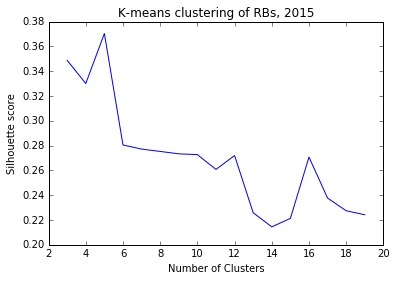

In [31]:
k = list(range(3,20))

scores = dict.fromkeys(k)

data = scale(rbs[['RA','SRA','RY','TDR','REC','SNP','FUML']].values)

for size in k:
    kmeans = KMeans(n_clusters=size)
    kmeans.fit(data)
    scores[size] = silhouette_score(data,kmeans.labels_)
    
plt.plot(k,scores.values())
plt.title('K-means clustering of RBs, 2015')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')

The plot shows that the silhouette score peaks at 5 clusters. Let's take a look at the data for 5 clusters:

In [34]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)

clusters = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['RA','SRA','RY','TDR','REC','SNP','FUML'])

rbs['cluster']=kmeans.labels_

clusters

,RA,SRA,RY,TDR,REC,SNP,FUML
0,0.762913,0.751662,0.734006,0.758807,-0.074378,0.380181,0.343072
1,-0.656735,-0.651389,-0.653844,-0.560074,-0.502982,-0.635429,-0.361874
2,-0.919334,-1.037666,-1.139927,-0.743613,-1.126940,-1.405851,5.932691
3,1.846033,1.829351,1.831705,1.522471,1.008847,1.732514,0.569700
4,-0.150819,-0.121616,-0.063274,-0.265497,1.821031,0.692648,-0.066976


The table shows the 5 clusters broken out into the variables we input into the model. Cluster 3 is the cluster of top-performing backs. Remember, these numbers are scaled, so the number of rushing touchdowns (TDR) cluster 3 running backs score is 1.522 standard deviations above the mean for all running backs. Let's take a look at who is in this group.

In [91]:
rbs3 = rbs3[rbs3.cluster == 3]
rbs_table = rbs3[rbs3['TDR']>.5]
rbs_table

,RA,SRA,RY,TDR,REC,cluster
PNAME,,,,,,
A.Peterson,20.588235,8.882353,90.000000,0.647059,1.882353,3
D.Freeman,17.600000,8.066667,70.733333,0.733333,4.866667,3
J.Charles,14.200000,6.800000,72.800000,0.800000,4.200000,3
J.Hill,13.823529,6.588235,49.647059,0.705882,1.058824,3
J.Stewart,18.250000,8.062500,75.437500,0.562500,1.250000,3
T.Gurley,17.615385,7.538462,85.230769,0.769231,1.615385,3
T.Hightower,16.000000,9.000000,62.500000,0.666667,2.000000,3


Looking at the cluster 3 running backs, our clustering seems correct. Top performing backs like Adrian Peterson, Todd Gurley, and Jamaal Charles are captured in the cluster.

**Things to Consider**

1. Measuring clustering performance requires a solid metric like the silhouette score. There are several other ways to
measure performance (for more ways, check scikit-learn's documentation http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)

2. The data is scaled before clustering. The means are subtracted off each observation, then divided by the standard deviation. 

3. The clustering will change with the variables you use. Eliminating variables like 'Successful Rushing Attempts' will move some players out of clusters and into others. 